In [1]:
# https://github.com/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb
# https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook
# https://towardsdatascience.com/time-series-forecasting-with-deep-learning-in-pytorch-lstm-rnn-1ba339885f0c
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from lib.predict import split_data, GRU
import torch
import torch.nn as nn
import chart_studio.plotly as py
import chart_studio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
class StockPredict:
    
    def __init__(self, stock_prices_filename):
        self.input_dim = 1
        self.hidden_dim = 32
        self.num_layers = 2
        self.output_dim = 1
        self.num_epochs = 100
        self.lookback = 20 # choose sequence length

        self.data = pd.read_csv(stock_prices_filename)
        self.price = pd.DataFrame(self.data[['Close']])
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.price.loc[:,"Close"] = self.scaler.fit_transform(self.price.values.reshape(-1,1))
        
        x_train, y_train, x_test, y_test = split_data(self.price, self.lookback)

        # create tensors 
        self.x_train = torch.from_numpy(x_train).type(torch.Tensor)
        self.x_test = torch.from_numpy(x_test).type(torch.Tensor)
        self.y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
        self.y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
        
        self.model = GRU(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim, 
            output_dim=self.output_dim, 
            num_layers=self.num_layers
        )
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=0.01)
        
        self.hist = np.zeros(self.num_epochs)
        self.y_train_pred = None
        self.training_time = 0

        
    def train(self):
        start_time = time.time()

        for t in range(self.num_epochs):
            self.y_train_pred = self.model(self.x_train)

            loss = self.criterion(self.y_train_pred, self.y_train_gru)
            # print("Epoch ", t, "MSE: ", loss.item())
            self.hist[t] = loss.item()

            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

        self.training_time = time.time()-start_time    
        print("Training time: {}".format(self.training_time))
        

In [212]:
sp = StockPredict("spydata.csv")
sp.train()

2012
1992
Training time: 14.62381887435913


In [213]:
predict = pd.DataFrame(sp.scaler.inverse_transform(sp.y_train_pred.detach().numpy()))
original = pd.DataFrame(sp.scaler.inverse_transform(sp.y_train_gru.detach().numpy()))

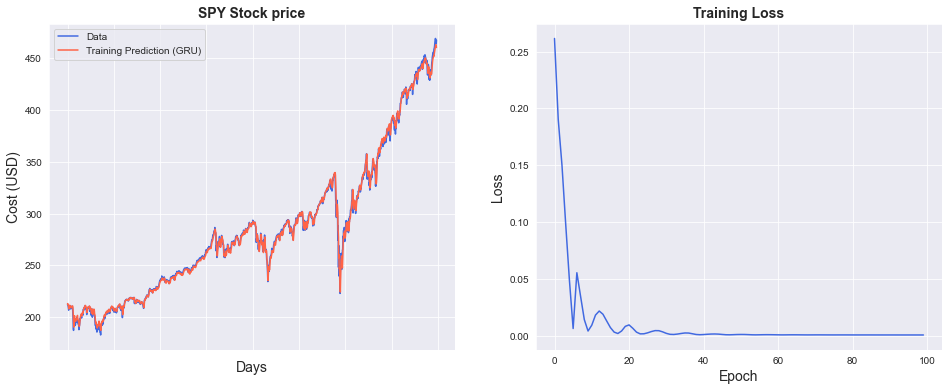

In [214]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('SPY Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=sp.hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

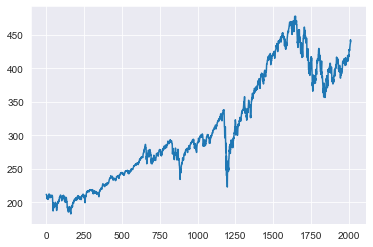

In [215]:
sp.data["Close"].plot()

In [442]:
sp.x_test.numpy().shape

(398, 19, 1)

In [391]:
pred = sp.model(sp.x_test)
pred = sp.scaler.inverse_transform(pred.detach().numpy())
orig = sp.scaler.inverse_transform(sp.price["Close"].to_numpy().reshape(-1,1))
test = sp.scaler.inverse_transform(sp.x_test.numpy()[0:-1,-1,:])

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd7cbd0460>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd7cbd0460>)

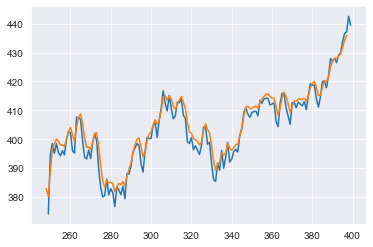

In [439]:
t = orig[-test.shape[0]-3:]
pd.DataFrame(t)[0][-151:].plot(), pd.DataFrame(pred)[0][-150:].plot() # , pd.DataFrame(t)[0][-150:].plot()

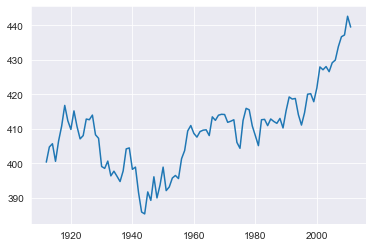

In [408]:
pd.DataFrame(orig)[0][-100:].plot()

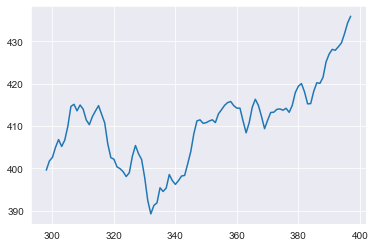

In [363]:
pd.DataFrame(pred)[0][-100:].plot()

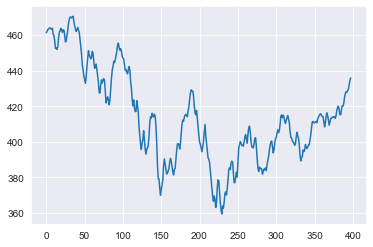

In [336]:
y_test_pred = sp.model(sp.x_test)

dt = sp.scaler.inverse_transform(pred.detach().numpy().reshape(-1,1))
pd.DataFrame(dt)[0].plot()

In [216]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = sp.model(sp.x_test)

# invert predictions
y_train_pred = sp.scaler.inverse_transform(sp.y_train_pred.detach().numpy())
y_train = sp.scaler.inverse_transform(sp.y_train_gru.detach().numpy())
y_test_pred = sp.scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = sp.scaler.inverse_transform(sp.y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru = []
gru.append(trainScore)
gru.append(testScore)
gru.append(sp.training_time)

Train Score: 3.51 RMSE
Test Score: 6.54 RMSE


In [222]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(sp.price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sp.lookback:len(y_train_pred)+sp.lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(sp.price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+sp.lookback-1:len(sp.price)-1, :] = y_test_pred

original = sp.scaler.inverse_transform(sp.price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

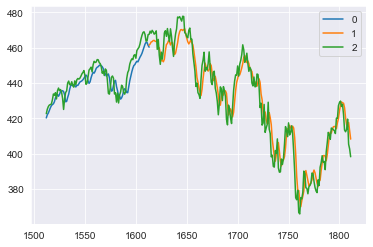

In [272]:
result[-500:-200].plot(y=[0, 1, 2])

In [218]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

# fig.show()

In [219]:
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,GRU
Train RMSE,3.505303
Test RMSE,6.543382
Train Time,14.623819


In [220]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='meetri', api_key='EHX9ay0cDEjFpoVbro8d')
py.iplot(fig, filename='stock_prediction_gru')
